In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os
import copy

In [51]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [52]:
dir = '../data_vectors/cosmodc2/2022/feb11/'

file = 'twopoint_data_real.sacc' 
d = sacc.Sacc.load_fits(dir+file)
file = 'twopoint_theory_real.sacc'
t = sacc.Sacc.load_fits(dir+file)

file = 'summary_statistics_real.sacc'
t_cov = sacc.Sacc.load_fits(dir+file)
make_directory(dir + 'plots/')
for dt in d.get_data_types():
        print(dt)
print ('----')
for dt in t.get_data_types():
        print(dt)
print ('----') 

galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----
galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----


In [5]:
W = "galaxy_density_xi"
GAMMA = "galaxy_shearDensity_xi_t"
GAMMAX = "galaxy_shearDensity_xi_x"
XIP = "galaxy_shear_xi_plus"
XIM = "galaxy_shear_xi_minus"
EE = "galaxy_shear_cl_ee"
DD = "galaxy_density_cl"
ED = "galaxy_shearDensity_cl_e"

In [6]:
c = ['teal', 'powderblue', 'orange',  'cornflowerblue', 'tomato',  'gray']
zs = [0.19285902, 0.40831394, 0.65503818, 0.94499109, 1.2947086, 1.72779632, 2.27855242, 3. ] 
nsbins = len(zs)-1
def convert_to_z_labels(z):
    return ['$%0.2f < z < %0.2f$'%(z[i], z[i+1]) for i in range(len(z)-1)]
zs_labels = convert_to_z_labels(zs)
print(zs_labels)

# Lens sample
zl = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
nlbins = len(zl)-1
zl_labels = convert_to_z_labels(zl)
print(zl_labels)

['$0.19 < z < 0.41$', '$0.41 < z < 0.66$', '$0.66 < z < 0.94$', '$0.94 < z < 1.29$', '$1.29 < z < 1.73$', '$1.73 < z < 2.28$', '$2.28 < z < 3.00$']
['$0.15 < z < 0.30$', '$0.30 < z < 0.45$', '$0.45 < z < 0.60$', '$0.60 < z < 0.75$', '$0.75 < z < 0.90$']


## Load covariance from CosmoCov

In [7]:
def get_cov(filename):

        data = np.genfromtxt(filename)
        ndata = int(np.max(data[:,0]))+1

        print("Dimension of cov: %dx%d"%(ndata,ndata))

        ndata_min = int(np.min(data[:,0]))
        cov_g = np.zeros((ndata,ndata))
        cov_ng = np.zeros((ndata,ndata))
        for i in range(0,data.shape[0]):
                cov_g[int(data[i,0]),int(data[i,1])] = data[i,8]
                cov_g[int(data[i,1]),int(data[i,0])] = data[i,8]
                cov_ng[int(data[i,0]),int(data[i,1])] = data[i,9]
                cov_ng[int(data[i,1]),int(data[i,0])] = data[i,9]

        return cov_g, cov_ng, ndata, data
    

def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

def get_xip_diag(file):
    
    xip_cov = file.covariance.covmat[1170:].T[1170:]
    return np.sqrt(np.diag(xip_cov))

def get_xim_diag(file):   
    xim_cov = file.covariance.covmat[750:1170].T[750:1170]
    return np.sqrt(np.diag(xim_cov))

def get_gt_diag(file):   
    gt_cov = file.covariance.covmat[225:750].T[225:750]
    return np.sqrt(np.diag(gt_cov))

def get_w_diag(file):   
    w_cov = file.covariance.covmat[:].T[:225]
    return np.sqrt(np.diag(w_cov))

In [9]:
path_cosmocov = '../data_vectors/cosmodc2/7sbins/cov_CosmoCOV/non-gaussian_3x2pt_with_shape_noise/'
path_cosmocov_cov, cov_type = path_cosmocov + 'cov_cosmodc2_3x2pt', '3x2'
#path_cosmocov = '../data_vectors/cosmodc2/7sbins/cov_CosmoCOV/non-gaussian_xip_with_shape_noise/'
#path_cosmocov_cov, cov_type = path_cosmocov + 'cov_cosmodc2_xip_ng_with_sn', 'xip'
cov_g, cov_ng, ndata, data = get_cov(path_cosmocov_cov)
err_g = np.sqrt(np.diag(cov_g))
err_ng = np.sqrt(np.diag(cov_ng))
err_t = np.sqrt(np.diag(cov_g + cov_ng))
cov_cosmocov_total = cov_g+cov_ng

Dimension of cov: 1440x1440


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [10]:
if cov_type == '3x2':
    nxip = 420
    ngt = nlbins*nsbins*15
    nw = nlbins*15
    
    xip_g = err_g[:nxip]
    xip_ng = err_ng[:nxip]
    xip_total = err_t[:nxip]

    xim_g = err_g[nxip:nxip*2]
    xim_ng = err_ng[nxip:nxip*2]
    xim_total = err_t[nxip:nxip*2]
    
    gt_g = err_g[nxip*2:nxip*2+ngt]
    gt_ng = err_ng[nxip*2:nxip*2+ngt]
    gt_total = err_t[nxip*2:nxip*2+ngt]
    
    w_g = err_g[nxip*2+ngt:]
    w_ng = err_ng[nxip*2+ngt:]
    w_total = err_t[nxip*2+ngt:] 
    
if cov_type == 'xip':
    xip_g = err_g
    xip_ng = err_ng
    xip_total = err_t

# run with shape noise
JK_xip = get_xip_diag(d)
txpipe_xip = get_xip_diag(t_cov)

JK_xim = get_xim_diag(d)
txpipe_xim = get_xim_diag(t_cov)

JK_gt = get_gt_diag(d)
txpipe_gt = get_gt_diag(t_cov)

JK_w = get_w_diag(d)
txpipe_w = get_w_diag(t_cov)

## Plot diagonal errorbars in the original order of the files

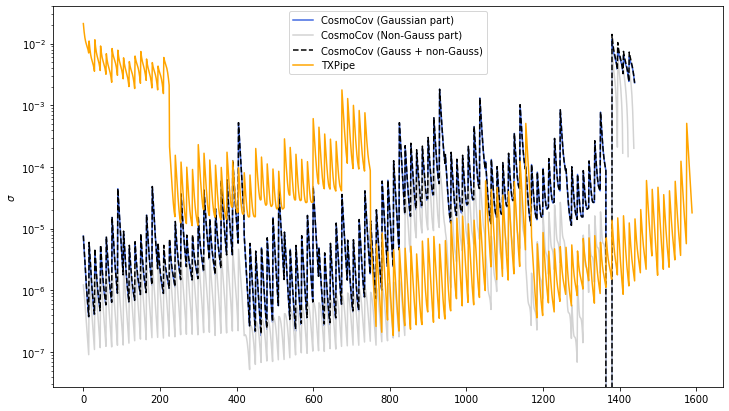

In [14]:
plt.figure(figsize = (12, 7))
dim = len(err_g)
dim_txpipe = len(np.sqrt(np.diag(t_cov.covariance.covmat))) # it is larger because it has wtheta cross-correlations.
#plt.plot(np.arange(nxip), np.sqrt(np.diag(t_re.covariance.covmat)), color = 'firebrick', label = 'Test', lw = 3)
plt.plot(np.arange(dim), err_g, '-', color = 'royalblue', label = 'CosmoCov (Gaussian part)')
plt.plot(np.arange(dim), err_ng, '-', color = 'lightgray', label = 'CosmoCov (Non-Gauss part)')
plt.plot(np.arange(dim), err_t, '--', color = 'k', label = 'CosmoCov (Gauss + non-Gauss)')
plt.plot(np.arange(dim_txpipe), np.sqrt(np.diag(t_cov.covariance.covmat)), '-', color = 'orange', label = 'TXPipe')
plt.plot()
plt.ylabel(r'$\sigma$')
plt.legend()
plt.yscale('log')

Text(0.5, 1.0, 'With shape noise')

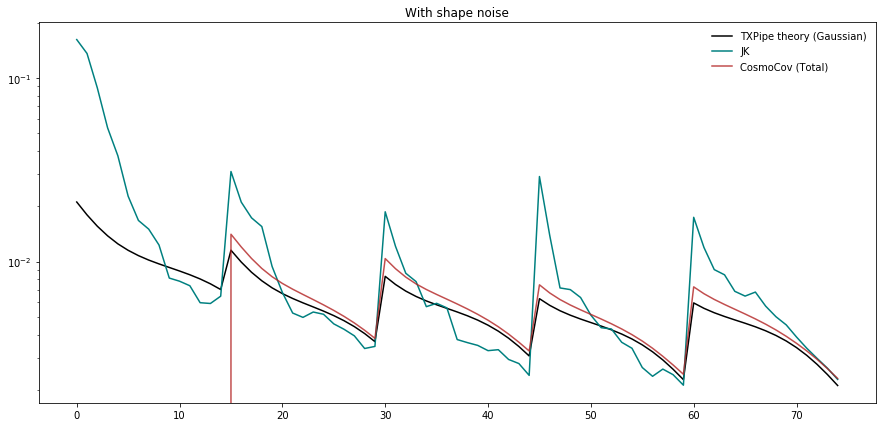

In [84]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(nw), txpipe_w_auto, '-', color = 'black', label = 'TXPipe theory (Gaussian)')
plt.plot(np.arange(nw), JK_w_auto, '-', color = 'teal', label = 'JK')
plt.plot(np.arange(nlbins*15), w_total, '-', color = 'firebrick', label = 'CosmoCov (Total)', alpha = 0.8)
#plt.plot(np.arange(w), reorder_CosmoCov_gt_total, '-', color = 'gold', label = 'CosmoCov (Total)', alpha = 0.8)


plt.legend(frameon=False)
plt.yscale('log')
plt.title('With shape noise')


In [85]:
w_total

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01407557, 0.01200353, 0.01038757, 0.00916492, 0.00826377,
       0.00759471, 0.0070672 , 0.00661525, 0.00620117, 0.00580493,
       0.00541481, 0.00502359, 0.00462664, 0.00422224, 0.00381542,
       0.01037445, 0.00913973, 0.00822287, 0.0075515 , 0.00703991,
       0.00661549, 0.00623355, 0.00587053, 0.00551373, 0.00515512,
       0.00478917, 0.00441223, 0.00402469, 0.00363441, 0.00325629,
       0.00746489, 0.00673989, 0.0062059 , 0.00579557, 0.00545494,
       0.00515052, 0.00486247, 0.00457873, 0.00429149, 0.00399564,
       0.0036882 , 0.00336915, 0.00304578, 0.00273136, 0.00243152,
       0.00727662, 0.00667708, 0.00621523, 0.0058341 , 0.00549564,
       0.0051781 , 0.00486788, 0.00455636, 0.00423884, 0.0039143 ,
       0.00358543, 0.00325802, 0.00293326, 0.00261252, 0.00230

# Reorder CosmoCov diagonal errors for xip and xim

In [15]:
if cov_type == '3x2': 
    name_order = 'cosmodc2'
    path_order = path_cosmocov 
if cov_type == 'xip': 
    name_order = 'no_shape_noise'
    path_order = '../data_vectors/cosmodc2/7sbins/cov_CosmoCOV/gaussian_xip/'

In [16]:
# Find what index corresponds to in the CosmoCov covariance. z1s and z2s indicate the zbinning for each index
indexes = []
z1s = []
z2s = []
n_th = 15
corr_types = []

for i in range(0,nxip):#data.shape[0]):
        if i%n_th==0 and i<ndata:
            index, _, corr_type, z1, z2 = np.genfromtxt(path_order + 'order_%s_i_%d-%d'%(name_order, i, i + n_th-1), dtype ='str', unpack = True)
            indexes.extend([int(j) for j in index])
            z1s.extend(z1)
            z2s.extend(z2)
            corr_types.extend(corr_type)

corr_types = np.array(corr_types)
assert np.sum(corr_types=='xi+')==len(corr_types) # check we're only getting the xip correlation

# now figure out the order we want things in
nzbins = 7
source1 = []
source2 = []
source1_extended = []
source2_extended = []
for zbin1 in range(nzbins):
        for zbin2 in range(nzbins):
            if zbin1>=zbin2:
                # this is the order TXPipe uses
                source1.append('s%d'%zbin1)
                source2.append('s%d'%zbin2)
                source1_extended.extend(['s%d'%zbin1]*n_th)
                source2_extended.extend(['s%d'%zbin2]*n_th)
print(source1, source2)

##############################################################
count = 0
ndata = nxip
reorder_CosmoCov_xip_g = np.zeros(ndata)
reorder_CosmoCov_xip_ng = np.zeros(ndata)
reorder_CosmoCov_xip_total = np.zeros(ndata)

if cov_type == '3x2':
    reorder_CosmoCov_xim_g = np.zeros(ndata)
    reorder_CosmoCov_xim_ng = np.zeros(ndata)
    reorder_CosmoCov_xim_total = np.zeros(ndata)

# indices to pass to the reorder function, to convert the TXPipe order to CosmoCov
ind_xip = np.arange(1170, 1170+nxip)
ind_xim = np.arange(750, 1170)
ind_reorder_xip = []
ind_reorder_xim = []

for i in range(0,ndata):
    if i%n_th==0 and i<ndata:       
        #print(source2[count], source1[count])     
        mask = np.in1d(z1s,source2[count])&np.in1d(z2s,source1[count])
        mask2 = np.in1d(source2_extended, z1s[i:i+n_th])&np.in1d(source1_extended,z2s[i:i+n_th])
        ind_reorder_xip.extend(ind_xip[mask2])
        ind_reorder_xim.extend(ind_xim[mask2])
        #if i ==45:
        #    print(mask)
        reorder_CosmoCov_xip_g[i:i+n_th] = xip_g[mask]
        reorder_CosmoCov_xip_ng[i:i+n_th] = xip_ng[mask]
        reorder_CosmoCov_xip_total[i:i+n_th] = xip_total[mask]
        
        if cov_type == '3x2':
            reorder_CosmoCov_xim_g[i:i+n_th] = xim_g[mask]
            reorder_CosmoCov_xim_ng[i:i+n_th] = xim_ng[mask]
            reorder_CosmoCov_xim_total[i:i+n_th] = xim_total[mask]
        
        count += 1 
    


['s0', 's1', 's1', 's2', 's2', 's2', 's3', 's3', 's3', 's3', 's4', 's4', 's4', 's4', 's4', 's5', 's5', 's5', 's5', 's5', 's5', 's6', 's6', 's6', 's6', 's6', 's6', 's6'] ['s0', 's0', 's1', 's0', 's1', 's2', 's0', 's1', 's2', 's3', 's0', 's1', 's2', 's3', 's4', 's0', 's1', 's2', 's3', 's4', 's5', 's0', 's1', 's2', 's3', 's4', 's5', 's6']


## Reorder diagonal errors for gammat

In [17]:
# Find what index corresponds to in the CosmoCov covariance. z1s and z2s indicate the zbinning for each index
indexes = []
lens = []
source = []
n_th = 15
corr_types = []
ndata = ngt
for i in range(nxip*2,nxip*2 + ngt):
        if i%n_th==0 and i<nxip*2 + ngt:
            index, _, corr_type, z1, z2 = np.genfromtxt(path_order + 'order_%s_i_%d-%d'%(name_order, i, i + n_th-1), dtype ='str', unpack = True)
            indexes.extend([int(j) for j in index])
            lens.extend(z1)
            source.extend(z2)
            corr_types.extend(corr_type)

corr_types = np.array(corr_types)
assert np.sum(corr_types=='gammat')==len(corr_types) # check we're only getting the xip correlation
print(z1, z2)
# now figure out the order we want things in
lens_tx = []
source_tx = []
lens_tx_extended = []
source_tx_extended = []
for zs in range(nsbins):
    for zl in range(nlbins):
            # this is the order TXPipe uses
            lens_tx.append('l%d'%zl)
            source_tx.append('s%d'%zs)
            
            lens_tx_extended.extend(['l%d'%zl]*n_th)
            source_tx_extended.extend(['s%d'%zs]*n_th)
            
print(lens_tx, source_tx)


# indices to pass to the reorder function, to convert the TXPipe order to CosmoCov
ind_gt = np.arange(225,750)
ind_reorder_gt = []

##############################################################
count = 0
ndata = ngt
reorder_CosmoCov_gt_g = np.zeros(ndata)
reorder_CosmoCov_gt_ng = np.zeros(ndata)
reorder_CosmoCov_gt_total = np.zeros(ndata)

for i in range(0,ndata):
    if i%n_th==0 and i<ndata:       
        #print(source2[count], source1[count])     
        mask = np.in1d(source,source_tx[count])&np.in1d(lens,lens_tx[count])
        mask2 = np.in1d(source_tx_extended, source[i:i+n_th])&np.in1d(lens_tx_extended,lens[i:i+n_th])
        ind_reorder_gt.extend(ind_gt[mask2])
        
        reorder_CosmoCov_gt_g[i:i+n_th] = gt_g[mask]
        reorder_CosmoCov_gt_ng[i:i+n_th] = gt_ng[mask]
        reorder_CosmoCov_gt_total[i:i+n_th] = gt_total[mask]
        
        count += 1 
    



['l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4'
 'l4'] ['s6' 's6' 's6' 's6' 's6' 's6' 's6' 's6' 's6' 's6' 's6' 's6' 's6' 's6'
 's6']
['l0', 'l1', 'l2', 'l3', 'l4', 'l0', 'l1', 'l2', 'l3', 'l4', 'l0', 'l1', 'l2', 'l3', 'l4', 'l0', 'l1', 'l2', 'l3', 'l4', 'l0', 'l1', 'l2', 'l3', 'l4', 'l0', 'l1', 'l2', 'l3', 'l4', 'l0', 'l1', 'l2', 'l3', 'l4'] ['s0', 's0', 's0', 's0', 's0', 's1', 's1', 's1', 's1', 's1', 's2', 's2', 's2', 's2', 's2', 's3', 's3', 's3', 's3', 's3', 's4', 's4', 's4', 's4', 's4', 's5', 's5', 's5', 's5', 's5', 's6', 's6', 's6', 's6', 's6']


## Reorder diagonal errorbars for wtheta

In [18]:
# Find what index corresponds to in the CosmoCov covariance. z1s and z2s indicate the zbinning for each index
indexes = []
l1s = []
l2s = []
n_th = 15
corr_types = []
ndata = nw
for i in range(nxip*2+ngt,nxip*2 + ngt+nw):
        if i%n_th==0 and i<nxip*2 + ngt+nw:
            index, _, corr_type, z1, z2 = np.genfromtxt(path_order + 'order_%s_i_%d-%d'%(name_order, i, i + n_th-1), dtype ='str', unpack = True)
            indexes.extend([int(j) for j in index])
            l1s.extend(z1)
            l2s.extend(z2)
            corr_types.extend(corr_type)

corr_types = np.array(corr_types)
assert np.sum(corr_types=='w')==len(corr_types) # check we're only getting the xip correlation
print(z1, z2)
# now figure out the order we want things in
lens1_tx = []
lens2_tx = []
lens1_tx_extended = []
lens2_tx_extended = []
for zl1 in range(nlbins):
    for zl2 in range(nlbins):
        if zl1>=zl2:
            # this is the order TXPipe uses
            lens1_tx.append('l%d'%zl1)
            lens2_tx.append('l%d'%zl2)
            lens1_tx_extended.extend(['l%d'%zl1]*n_th)
            lens2_tx_extended.extend(['l%d'%zl2]*n_th)
print(lens1_tx, lens2_tx)


# indices to pass to the reorder function, to convert the TXPipe order to CosmoCov
ind_w = np.arange(0, 225)
ind_reorder_w = []
##############################################################
# Edit the txpipe arrays to only have the auto correlations
mask_auto_txpipe = np.repeat(np.array(lens1_tx)==np.array(lens2_tx), n_th)
JK_w_auto = JK_w[mask_auto_txpipe]
txpipe_w_auto = txpipe_w[mask_auto_txpipe]
ind_reorder_w = list(ind_w[mask_auto_txpipe])

# there is no need to reorder the CosmoCov in this case since there is only the auto correlations. 
    



['l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4'
 'l4'] ['l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4' 'l4'
 'l4']
['l0', 'l1', 'l1', 'l2', 'l2', 'l2', 'l3', 'l3', 'l3', 'l3', 'l4', 'l4', 'l4', 'l4', 'l4'] ['l0', 'l0', 'l1', 'l0', 'l1', 'l2', 'l0', 'l1', 'l2', 'l3', 'l0', 'l1', 'l2', 'l3', 'l4']


## Reorder the sacc file using the indices above and the reorder sacc function to match the CosmoCov one

In [36]:
t_reordered = copy.copy(t_cov)
t_reordered.reorder(ind_reorder_xip+ ind_reorder_xim+ind_reorder_gt+ind_reorder_w) # this will have the original CosmoCov ordering
# remove the first lens bin because the non-gaussian part is weird in cosmocov

### Check that the reordering worked

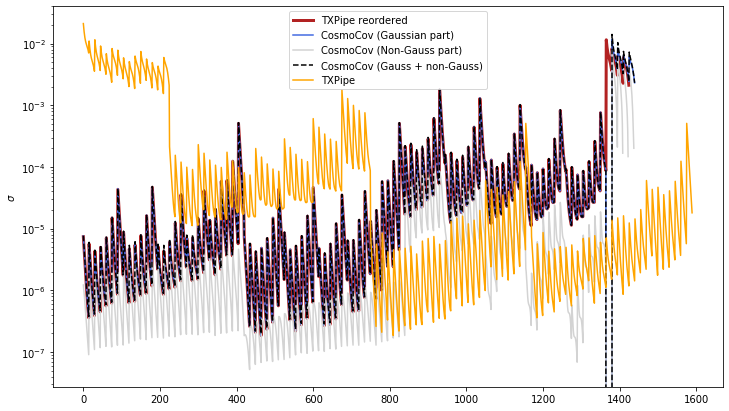

In [20]:
plt.figure(figsize = (12, 7))
dim = len(err_g)
dim_txpipe = len(np.sqrt(np.diag(t_cov.covariance.covmat))) # it is larger because it has wtheta cross-correlations.
plt.plot(np.arange(dim-15), np.sqrt(np.diag(t_reordered.covariance.covmat)), color = 'firebrick', label = 'TXPipe reordered', lw = 3)
plt.plot(np.arange(dim), err_g, '-', color = 'royalblue', label = 'CosmoCov (Gaussian part)')
plt.plot(np.arange(dim), err_ng, '-', color = 'lightgray', label = 'CosmoCov (Non-Gauss part)')
plt.plot(np.arange(dim), err_t, '--', color = 'k', label = 'CosmoCov (Gauss + non-Gauss)')
plt.plot(np.arange(dim_txpipe), np.sqrt(np.diag(t_cov.covariance.covmat)), '-', color = 'orange', label = 'TXPipe')
plt.plot()
plt.ylabel(r'$\sigma$')
plt.legend()
plt.yscale('log')


### Plot both covariances together

In [21]:
def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

### Remove the first bin of clustering since it has weird values for non-gaussian cosmcocov and it is not invertible

In [22]:
indices_remove = np.arange(nxip*2+ngt,nxip*2+ngt+n_th)
all_ind = np.arange(1440)

In [23]:
mask_remove_bin1_clustering = np.in1d(all_ind,indices_remove)
mask_remove_bin1_clustering = ~mask_remove_bin1_clustering

In [24]:
cov_cosmocov_total_nobin1 = copy.copy(cov_cosmocov_total)
cov_cosmocov_total_nobin1 = (cov_cosmocov_total_nobin1[mask_remove_bin1_clustering]).T[mask_remove_bin1_clustering]
cov_cosmocov_total_nobin1.shape


(1425, 1425)

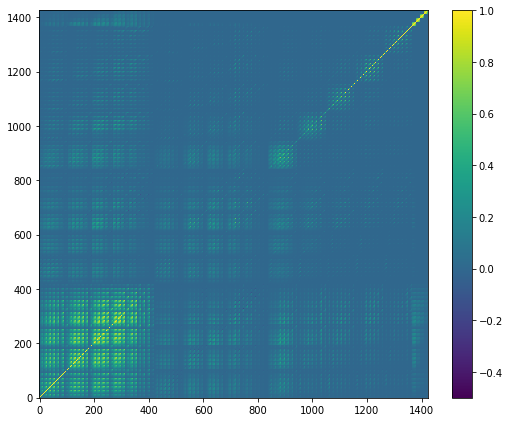

In [25]:
fig = plot_cov(cov_cosmocov_total_nobin1, 200)
plt.savefig('CosmoCov')

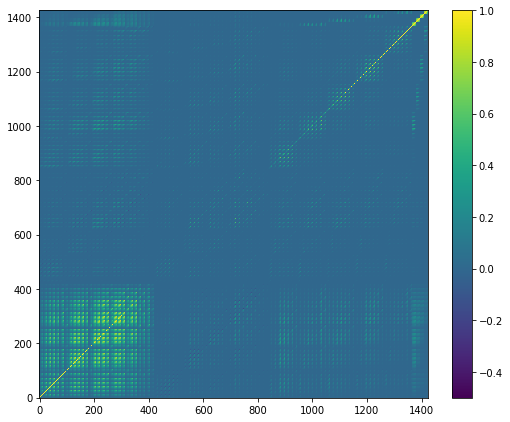

In [26]:
plot_cov(t_reordered.covariance.covmat, 200)

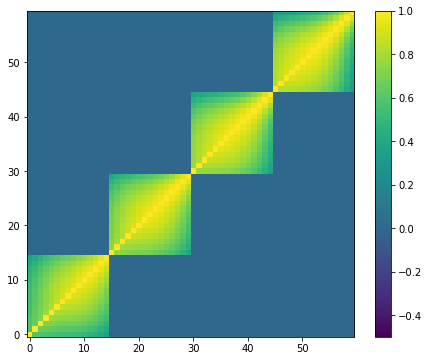

In [27]:
plot_cov((cov_cosmocov_total[nxip*2+ngt+n_th:]).T[nxip*2+ngt+n_th:], 10)

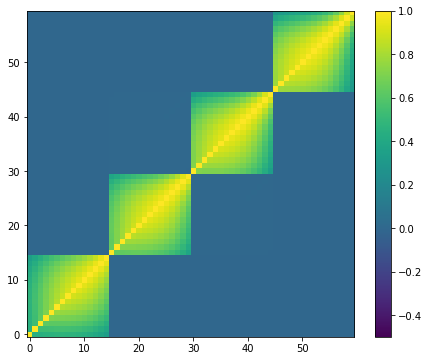

In [28]:
plot_cov((t_reordered.covariance.covmat[nxip*2+ngt:]).T[nxip*2+ngt:], 10)

## Save a sacc file with the CosmoCov covariance and the ordering of cosmocov

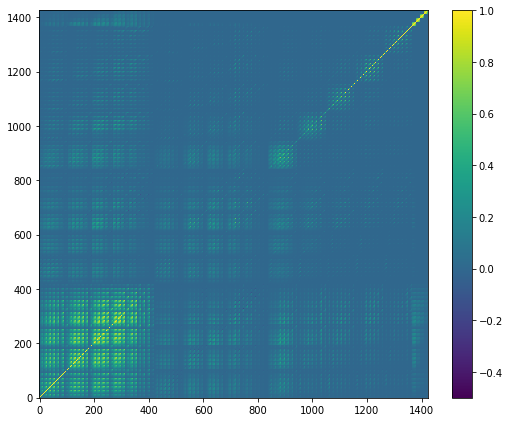

In [46]:
t_cosmocov = copy.copy(t_reordered)
t_cosmocov.add_covariance(cov_cosmocov_total)

t_cosmocov.remove_indices(~mask_remove_bin1_clustering)
plot_cov(t_cosmocov.covariance.covmat, 200)

t_cosmocov.save_fits(dir+'summary_statistics_real_with_CosmoCov_covariance_nobin1wtheta.sacc', overwrite=True)

In [49]:
# reorder the theory file too to compute chi2
t_theory_reordered = copy.copy(t)
t_theory_reordered.reorder(ind_reorder_xip+ ind_reorder_xim+ind_reorder_gt+ind_reorder_w)
t_theory_reordered.remove_indices(~mask_remove_bin1_clustering)
t_theory_reordered.save_fits(dir+'twopoint_theory_real_reordered_nobin1wtheta.sacc', overwrite=True)

## Load Namaster cov from Jackie (with shape noise)

In [15]:
cov_na_diag_sn = np.loadtxt('../data_vectors/cosmodc2/june_2021/7sbins/covariance_namaster/cov_xip.txt')

# Compare all errorbars

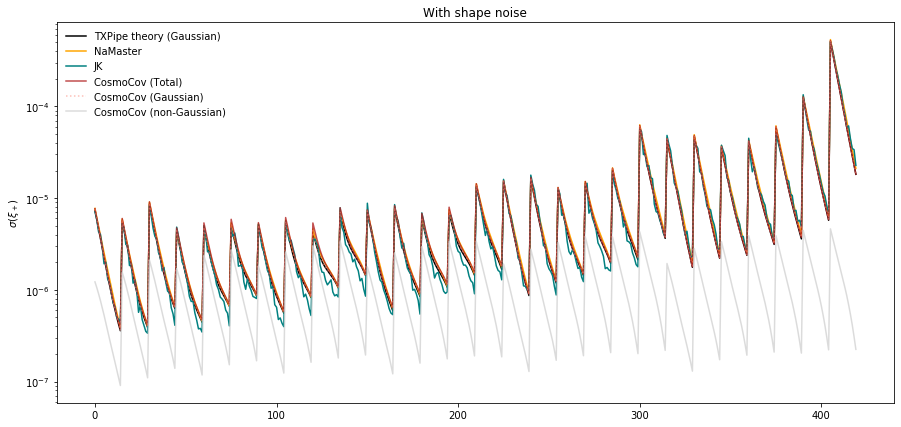

In [16]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(420), txpipe_xip, '-', color = 'black', label = 'TXPipe theory (Gaussian)')
plt.plot(np.arange(420), cov_na_diag_sn, '-', color = 'orange', label = 'NaMaster', alpha = 1.)
plt.plot(np.arange(420), JK_xip, '-', color = 'teal', label = 'JK')
plt.plot(np.arange(420), reorder_CosmoCov_xip_total, '-', color = 'firebrick', label = 'CosmoCov (Total)', alpha = 0.8)
plt.plot(np.arange(420), reorder_CosmoCov_xip_g, ':', color = 'salmon', label = 'CosmoCov (Gaussian)', alpha = 0.5)
plt.plot(np.arange(420), reorder_CosmoCov_xip_ng, '-', color = 'lightgray', label = 'CosmoCov (non-Gaussian)', alpha = 0.8)


plt.ylabel(r'$\sigma(\xi_+$)')
plt.legend(frameon=False)
plt.yscale('log')
plt.title('With shape noise')
plt.savefig('../plots/cov_comparison_xip.png', dpi = 400, bbox_inches = 'tight',  pad_inches = 0.1)

In [23]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(420), cov_na_diag_sn/txpipe_xip, '-', color = 'orange', label = 'NaMaster / TXPipe(Gaussian)', alpha = 1.)
plt.plot(np.arange(420), JK_xip/txpipe_xip, '-', color = 'teal', label = 'JK / TXPipe(Gaussian)', alpha = 0.4)

plt.plot(np.arange(420), reorder_CosmoCov_xip_total/txpipe_xip, '-', color = 'firebrick', label = 'CosmoCov (Total) / TXPipe(Gaussian)', alpha = 1.)
plt.plot(np.arange(420), reorder_CosmoCov_xip_total/reorder_CosmoCov_xip_g, '--', color = 'firebrick', label = 'CosmoCov (Total) / CosmoCov(Gaussian)', alpha = 0.6)
plt.plot(np.arange(420), reorder_CosmoCov_xip_g/txpipe_xip, '-', color = 'salmon', label = 'CosmoCov (Gaussian) / TXPipe(Gaussian)', alpha = 0.6)

plt.ylabel(r'$\sigma(\xi_+$)')
plt.axhline(y = 1, color = 'k', ls = ':')
plt.ylim(0.95, 1.1)
plt.legend(frameon=False)
#plt.title('With shape noise')
#plt.savefig('../plots/cov_comparison_xip_ratios.png', dpi = 400, bbox_inches = 'tight',  pad_inches = 0.1)

NameError: name 'cov_na_diag_sn' is not defined

<Figure size 1080x504 with 0 Axes>

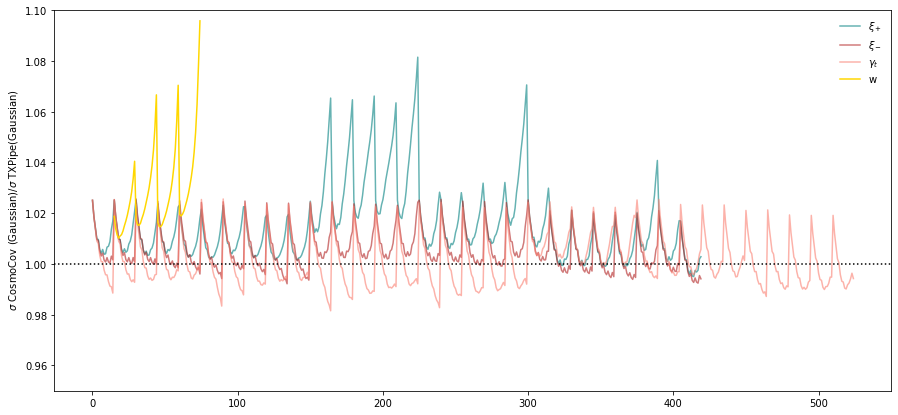

In [22]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(420), reorder_CosmoCov_xip_g/txpipe_xip, '-', color = 'teal', label = r'$\xi_+$', alpha = 0.6)
plt.plot(np.arange(420), reorder_CosmoCov_xim_g/txpipe_xim, '-', color = 'firebrick', label = r'$\xi_-$', alpha = 0.6)
plt.plot(np.arange(ngt), reorder_CosmoCov_gt_g/txpipe_gt, '-', color = 'salmon', label = r'$\gamma_t$', alpha = 0.6)
plt.plot(np.arange(nw)[15:], w_g[15:]/txpipe_w_auto[15:], '-', color = 'gold', label = 'w', alpha = 1.)


plt.ylabel(r' $\sigma$ CosmoCov (Gaussian)/$\sigma$ TXPipe(Gaussian)')
plt.axhline(y = 1, color = 'k', ls = ':')
plt.ylim(0.95, 1.1)
plt.legend(frameon=False)
#plt.title('With shape noise')
plt.savefig('../plots/cov_comparison_ratios_simple.png', dpi = 400, bbox_inches = 'tight',  pad_inches = 0.1)

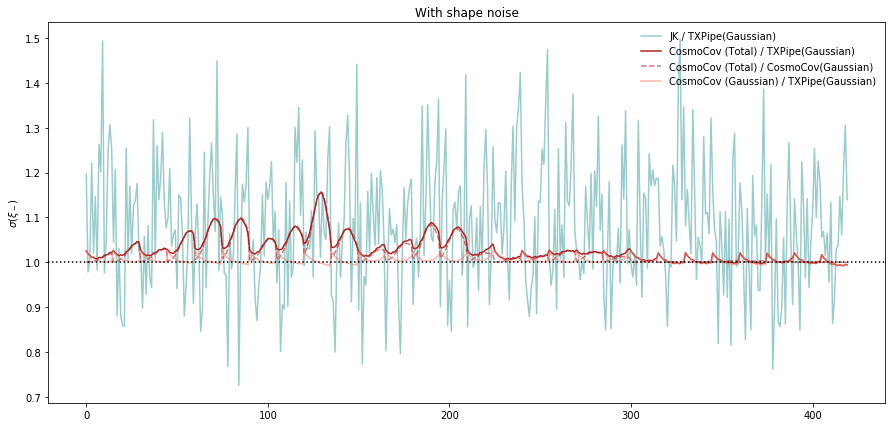

In [110]:
plt.figure(figsize = (15, 7))

#plt.plot(np.arange(420), cov_na_diag_sn/txpipe_xim, '-', color = 'orange', label = 'NaMaster / TXPipe(Gaussian)', alpha = 1.)
plt.plot(np.arange(420), JK_xim/txpipe_xim, '-', color = 'teal', label = 'JK / TXPipe(Gaussian)', alpha = 0.4)
#plt.plot(np.arange(420), JK_xim/reorder_CosmoCov_xim_total, '--', color = 'teal', label = 'JK / CosmoCov (Total)', alpha = 0.3)
plt.plot(np.arange(420), reorder_CosmoCov_xim_total/txpipe_xim, '-', color = 'firebrick', label = 'CosmoCov (Total) / TXPipe(Gaussian)', alpha = 1.)
plt.plot(np.arange(420), reorder_CosmoCov_xim_total/reorder_CosmoCov_xim_g, '--', color = 'firebrick', label = 'CosmoCov (Total) / CosmoCov(Gaussian)', alpha = 0.6)
plt.plot(np.arange(420), reorder_CosmoCov_xim_g/txpipe_xim, '-', color = 'salmon', label = 'CosmoCov (Gaussian) / TXPipe(Gaussian)', alpha = 0.6)

plt.ylabel(r'$\sigma(\xi_-$)')
plt.axhline(y = 1, color = 'k', ls = ':')
#plt.ylim(0.8, 1.05)
plt.legend(frameon=False)
plt.title('With shape noise')
plt.savefig('../plots/cov_comparison_xim_ratios.png', dpi = 400, bbox_inches = 'tight',  pad_inches = 0.1)

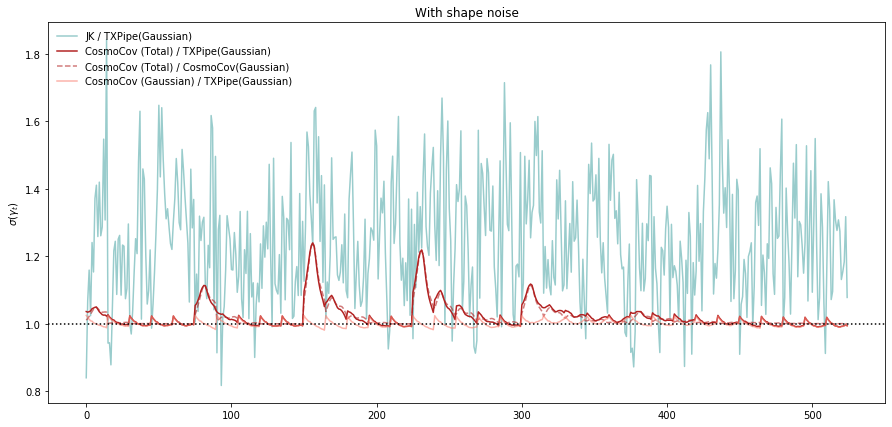

In [108]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(ngt), JK_gt/txpipe_gt, '-', color = 'teal', label = 'JK / TXPipe(Gaussian)', alpha = 0.4)
plt.plot(np.arange(ngt), reorder_CosmoCov_gt_total/txpipe_gt, '-', color = 'firebrick', label = 'CosmoCov (Total) / TXPipe(Gaussian)', alpha = 1.)
plt.plot(np.arange(ngt), reorder_CosmoCov_gt_total/reorder_CosmoCov_gt_g, '--', color = 'firebrick', label = 'CosmoCov (Total) / CosmoCov(Gaussian)', alpha = 0.6)
plt.plot(np.arange(ngt), reorder_CosmoCov_gt_g/txpipe_gt, '-', color = 'salmon', label = 'CosmoCov (Gaussian) / TXPipe(Gaussian)', alpha = 0.6)

plt.ylabel(r'$\sigma(\gamma_t)$')
plt.axhline(y = 1, color = 'k', ls = ':')
plt.legend(frameon=False)
#plt.ylim(0.8, 1.05)
plt.title('With shape noise')
plt.savefig('../plots/cov_comparison_gt_ratios.png', dpi = 400, bbox_inches = 'tight',  pad_inches = 0.1)

/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


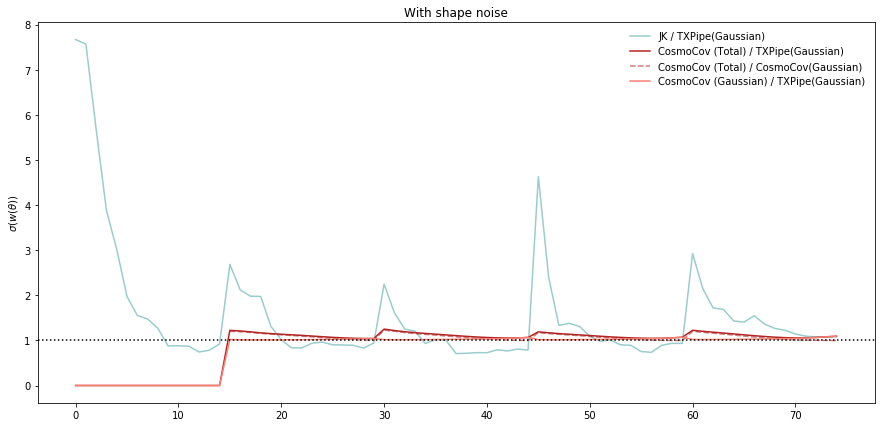

In [109]:
plt.figure(figsize = (15, 7))

plt.plot(np.arange(nw), JK_w_auto/txpipe_w_auto, '-', color = 'teal', label = 'JK / TXPipe(Gaussian)', alpha = 0.4)
plt.plot(np.arange(nw), w_total/txpipe_w_auto, '-', color = 'firebrick', label = 'CosmoCov (Total) / TXPipe(Gaussian)', alpha = 1.)
plt.plot(np.arange(nw), w_total/w_g, '--', color = 'firebrick', label = 'CosmoCov (Total) / CosmoCov(Gaussian)', alpha = 0.6)
plt.plot(np.arange(nw), w_g/txpipe_w_auto, '-', color = 'salmon', label = 'CosmoCov (Gaussian) / TXPipe(Gaussian)', alpha = 1.)

plt.ylabel(r'$\sigma(w(\theta)$)')
plt.axhline(y = 1, color = 'k', ls = ':')
plt.legend(frameon=False)
#plt.ylim(0.8, 1.08)
plt.title('With shape noise')
plt.savefig('../plots/cov_comparison_w_ratios.png', dpi = 400, bbox_inches = 'tight',  pad_inches = 0.1)

## Plot diagonal errors in other type of plot

In [38]:
def plot_errorbars(s, theory=None, theory_cov = None, datatype=None, ratios = False):
      
    for dt in s.get_data_types():
        
        if dt == XIP or dt == XIM:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == GAMMA:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == W:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            if dt == GAMMA:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
            else:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    theta, xi, cov = s.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                    err = np.sqrt(np.diag(cov))
                    
                    if theory is not None:
                        theta_th, xi_th = theory.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                        if theory_cov is not None:
                            _, _, cov_th = theory_cov.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err_th = np.sqrt(np.diag(cov_th))    
                    if ratios:
                        ax[i][j].plot(theta, err/err_th, lw = 2, label = 'Jackknife/Theory')
                    else:
                        ax[i][j].plot(theta, err, lw = 2, label = 'Jackknife')
                        ax[i][j].plot(theta, err_th, lw = 2, label = 'Theory')
                    ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(2, 110)
                    
                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    else:
                        if i==j:
                            plt.plot(theta, err_t[i*15:(i+1)*15])
                            
                        ax[i][j].set_yscale('log')
                        if datatype==XIP:
                            ax[i][j].set_ylim(10**(-7), 10**(-5))
                        if datatype==XIM:
                            ax[i][j].set_ylim(2*10**(-8), 3.5*10**(-5))  
                        if datatype==GAMMA:
                            ax[i][j].set_ylim(5*10**(-7), 4.*10**(-4))  
                        if datatype==W:
                            ax[i][j].set_ylim(10**(-5), 0.12)  

                    if i==nsbins-1: 
                        ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
                    if j==0:
                        if datatype==XIP:
                            ax[i][j].set_ylabel(r'$\xi_+$')
                        if datatype==XIM:
                            ax[i][j].set_ylabel(r'$\xi_-$')
                        if datatype==GAMMA:
                            ax[i][j].set_ylabel(r'$\gamma_t$')
                        if datatype==W:
                            ax[i][j].set_ylabel(r'$w(\theta)$')
                            
                    if datatype!=GAMMA:
                        if i<j:
                            fig.delaxes(ax[i, j])

    ax[0][0].legend(frameon = False, loc = 'lower left')

    return fig

In [ ]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov, datatype=XIP, ratios = False)
#plt.savefig(dir + 'plots/' + 'xip_errors.png', dpi = 300)